In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D,GlobalMaxPooling1D,MaxPooling1D
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,CuDNNLSTM
from tensorflow import keras
import string

In [57]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [58]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [59]:
import re
!pip install contractions
import contractions


i=0
for doc in train.comment_text:
    doc = doc.lower()
    doc=  re.sub(r"https?://\S+|www\.\S+",'', doc)  #Remove URLs from a sample string
    doc = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', doc) # clean url
    doc = re.sub(r'#(\w+)', '',doc)   # clean hashes
    doc = re.sub(r'[^\x00-\x7f]',r'', doc) #Remove non-ASCII characters 
    doc = re.sub(r'@(\w+)', '', doc)   # clean @
    doc = re.sub(r'<[^>]+>', '',doc)  # clean tags
    doc = re.sub(r'\d+', '',doc)      # clean digits
    doc=re.sub(r'<.*?>','',doc)
    doc = re.sub("#", " ",doc)
    doc = re.sub(":::", " ", doc)
    doc = re.sub("\n", " ",doc)
    doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
    punctuation = set(string.punctuation)  #remove the punctuation
    doc = "".join([p for p in doc if p not in punctuation])
    doc=contractions.fix(doc)
    train.comment_text[i]=doc
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [78]:
x=train["comment_text"]
y=train["Toxic"]

In [79]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=4,shuffle=True)

In [80]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"    
    
hub_layer = hub.KerasLayer(embedding,output_shape=[128], input_shape=[], dtype=tf.string, trainable=True)

In [81]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
bi_model=Sequential()
bi_model.add(hub_layer)
bi_model.add(tf.keras.layers.Reshape((1,128)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
bi_model.add(Dropout(0.3))
bi_model.add(Bidirectional(CuDNNLSTM(64))) #lstm with 64 neurons
bi_model.add(Dropout(0.3))
bi_model.add(Dense(1,activation='sigmoid'))
bi_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(bi_model.summary())

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_13 (Reshape)        (None, 1, 128)            0         
                                                                 
 dropout_22 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 1, 128)           99328     
 nal)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 1, 128)            0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              99328     
 nal)                                                

In [82]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=3, mode='auto', restore_best_weights=True)
history = bi_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 123ms/step - loss: 0.2619 - accuracy: 0.8914 - val_loss: 0.2294 - val_accuracy: 0.9086
Epoch 2/20
462/462 [==============================] - 56s 120ms/step - loss: 0.1304 - accuracy: 0.9492 - val_loss: 0.2448 - val_accuracy: 0.9038
Epoch 3/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0748 - accuracy: 0.9717 - val_loss: 0.3347 - val_accuracy: 0.8959
Epoch 4/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0481 - accuracy: 0.9809 - val_loss: 0.4402 - val_accuracy: 0.8907
Epoch 5/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0371 - accuracy: 0.9855 - val_loss: 0.4519 - val_accuracy: 0.8895
Epoch 6/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0276 - accuracy: 0.9900 - val_loss: 0.4970 - val_accuracy: 0.8889
Epoch 00006: early stopping


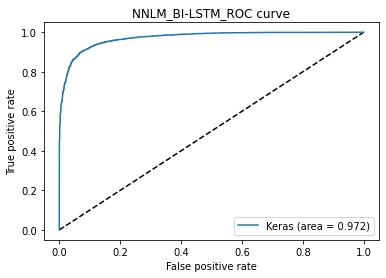

In [83]:
from sklearn.metrics import roc_curve
y_pred=bi_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_BI-LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [84]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.46694884
              precision    recall  f1-score   support

           0     0.9080    0.9322    0.9199      4289
           1     0.9235    0.8967    0.9099      3919

    accuracy                         0.9152      8208
   macro avg     0.9158    0.9144    0.9149      8208
weighted avg     0.9154    0.9152    0.9151      8208



In [85]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(LSTM(64))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_14 (Reshape)        (None, 1, 128)            0         
                                                                 
 lstm_13 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,161
Trainable params: 124,692,161
Non-trainable params: 0
_________________________________________________________________
None


In [86]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 58s 120ms/step - loss: 0.1696 - accuracy: 0.9379 - val_loss: 0.2480 - val_accuracy: 0.8998
Epoch 2/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0812 - accuracy: 0.9692 - val_loss: 0.3359 - val_accuracy: 0.8907
Epoch 3/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0447 - accuracy: 0.9827 - val_loss: 0.4032 - val_accuracy: 0.8901
Epoch 4/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0294 - accuracy: 0.9891 - val_loss: 0.5373 - val_accuracy: 0.8946
Epoch 5/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0188 - accuracy: 0.9928 - val_loss: 0.6380 - val_accuracy: 0.8858
Epoch 6/20
462/462 [==============================] - 54s 117ms/step - loss: 0.0178 - accuracy: 0.9932 - val_loss: 0.6513 - val_accuracy: 0.8910
Epoch 00006: early stopping


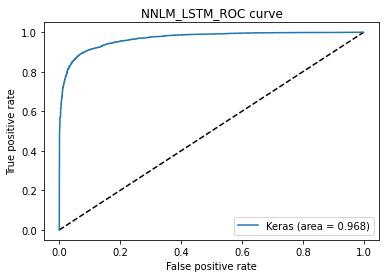

In [87]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [88]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.5515567
              precision    recall  f1-score   support

           0     0.9040    0.9282    0.9159      4289
           1     0.9190    0.8921    0.9053      3919

    accuracy                         0.9109      8208
   macro avg     0.9115    0.9101    0.9106      8208
weighted avg     0.9112    0.9109    0.9109      8208



In [89]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Dropout
lstm_model=Sequential()
lstm_model.add(hub_layer)
lstm_model.add(tf.keras.layers.Reshape((1,128)))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64,return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1,activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(3e-3),metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 128)               124642688 
                                                                 
 reshape_15 (Reshape)        (None, 1, 128)            0         
                                                                 
 dropout_26 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_14 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_27 (Dropout)        (None, 1, 64)             0         
                                                                 
 lstm_15 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)               

In [90]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=True)
history = lstm_model.fit(x=train_x, y=train_y, batch_size=64, verbose=1, epochs=20, validation_split= 0.1,shuffle=True,callbacks=[callback])

Epoch 1/20
462/462 [==============================] - 61s 123ms/step - loss: 0.1119 - accuracy: 0.9629 - val_loss: 0.3016 - val_accuracy: 0.8968
Epoch 2/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0629 - accuracy: 0.9776 - val_loss: 0.3533 - val_accuracy: 0.8934
Epoch 3/20
462/462 [==============================] - 55s 119ms/step - loss: 0.0419 - accuracy: 0.9835 - val_loss: 0.5173 - val_accuracy: 0.8931
Epoch 4/20
462/462 [==============================] - 56s 121ms/step - loss: 0.0273 - accuracy: 0.9899 - val_loss: 0.5409 - val_accuracy: 0.8922
Epoch 5/20
462/462 [==============================] - 55s 120ms/step - loss: 0.0239 - accuracy: 0.9912 - val_loss: 0.5168 - val_accuracy: 0.8904
Epoch 6/20
462/462 [==============================] - 56s 120ms/step - loss: 0.0174 - accuracy: 0.9934 - val_loss: 0.6082 - val_accuracy: 0.8870
Epoch 00006: early stopping


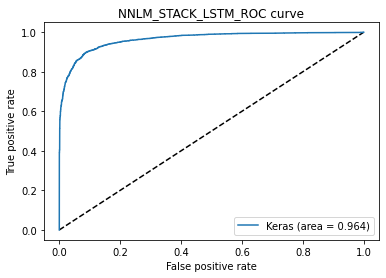

In [91]:
from sklearn.metrics import roc_curve
y_pred=lstm_model.predict(test_x).ravel()
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('NNLM_STACK_LSTM_ROC curve')
plt.legend(loc='best')
plt.show()

In [92]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
y=tpr-fpr
idx=np.argmax(y)#Youden_index
best_threshold=thresholds[idx]
print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred >best_threshold ,digits=4))

The best threshold is 0.5776153
              precision    recall  f1-score   support

           0     0.9067    0.9130    0.9099      4289
           1     0.9041    0.8972    0.9006      3919

    accuracy                         0.9055      8208
   macro avg     0.9054    0.9051    0.9052      8208
weighted avg     0.9054    0.9055    0.9054      8208

